# Data preprocess for model input

In [75]:
import pandas as pd
import numpy as np

## encode functions
##### main custom functions
def one_hot_encode(df,columns_for_one_hot):
    '''One hot encode the columns for feeding into the model
    :df: Dataframe of the data
    :columns_for_one_hot: array name of columns to input
    :return: Dataframe of the one hot encoded data with prefix = columns_for_one_hot
    '''
#     for col_index in columns_for_one_hot:
#         df[col_index]=df[col_index].replace(['0',0], 'No_{}'.format(col_index))
    ## one hot encode
    for column_for_one_hot in columns_for_one_hot:
        #  Get one hot encoding of columns B
        one_hot = pd.get_dummies(df[column_for_one_hot],prefix=column_for_one_hot)
        # Drop column B as it is now encoded
        df = df.drop(column_for_one_hot,axis = 1)
        # Join the encoded df
        df = df.join(one_hot,rsuffix=column_for_one_hot)
    return df
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

def evaluate(y_pred,Y_val,y_col):
    print('ycol is:',y_col)
    mse_sep=[round(mean_squared_error(Y_val[:,0], y_pred[:,0]),6),
         round(mean_squared_error(Y_val[:,1], y_pred[:,1]),6)]
    print('mean squared error is:', str(mse_sep))
    mae_sep=[round(mean_absolute_error(Y_val[:,0], y_pred[:,0]),6),
         round(mean_absolute_error(Y_val[:,1], y_pred[:,1]),6)]
    print('mean absolute error is:', str(mae_sep))
    mese_sep=[round(median_absolute_error(Y_val[:,0], y_pred[:,0]),6),
         round(median_absolute_error(Y_val[:,1], y_pred[:,1]),6)]
    print('median_absolute_error is:', str(mese_sep))

In [76]:
## read and encode data
dfg = pd.read_csv(
    './vintage_wine_description_processed.csv',index_col=0).fillna(0)
to_encode=['country','province','region_1','region_2','variety','area']
to_drop=['designation','description','title','Location_description','location','winery']
dfg=dfg.drop(to_drop,axis=1)
dfg=one_hot_encode(dfg,to_encode)
dfg.head()

,points,price,year,temp1,temp10,temp11,temp12,temp13,temp14,temp15,...,area_Eastern France,area_Jura,area_Languedoc,area_Languedoc-Roussillon,area_Loire,area_Lyonnais,area_Provence,area_Rhône,area_Savoy,area_South West France
0,87,0.0,2013,11.390,20.302,16.792,12.432,11.375,9.663,13.650,...,0,0,0,0,0,0,1,0,0,0
1,87,15.0,2011,4.690,12.437,7.362,4.967,5.142,6.502,8.337,...,0,0,0,0,1,0,0,0,0,0
2,87,14.0,2013,4.350,11.176,7.606,3.811,2.580,4.904,7.617,...,0,0,0,0,0,0,0,0,0,0
3,87,13.0,2013,-1.763,10.034,3.674,1.283,-2.770,-4.096,-0.363,...,0,0,0,0,0,0,0,0,0,0
4,87,65.0,2012,4.761,10.858,5.631,2.999,4.350,4.755,5.160,...,0,0,0,0,0,0,0,0,0,0


In [77]:
pd.read_csv(
    './vintage_wine_description_processed.csv',index_col=0).fillna(0).filter(regex='^(?!taste)').filter(regex='^(?!temp)').describe()


,points,price,year,latitude,longitude
count,125345.000000,125345.000000,125345.000000,125345.000000,125345.000000
mean,88.485819,33.083857,2010.677578,31.656560,-45.865747
std,3.040517,40.774575,3.715205,23.260992,71.801828
min,80.000000,0.000000,1904.000000,-44.854979,-125.002441
25%,86.000000,15.000000,2009.000000,36.701463,-118.755997
50%,88.000000,25.000000,2011.000000,38.645311,-74.006015
75%,91.000000,40.000000,2013.000000,43.979280,6.158551
max,100.000000,3300.000000,2017.000000,57.151067,178.020649


In [78]:
### split xy and filter out columns that are not needed
y_col=['points','price']
regex_out_taste='^(?!taste)'
X = dfg.filter(regex=regex_out_taste).drop(y_col, axis=1) # Training & Validation data
Y = dfg[y_col]              # Response / Target Variable
### normalize data
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X=scaler.fit_transform(X)
Y=scaler.fit_transform(Y)
# print(Y)

print(X.shape, Y.shape)

# Split training set so that we validate on 20% of the data
# Note that our algorithms will never have seen the validation 

np.random.seed(5875) # set random seed for reproducibility

from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = \
                train_test_split(X, Y, test_size=0.2)

print('Training Samples:', X_train.shape, Y_train.shape)
print('Validation Samples:', X_val.shape, Y_val.shape)

# train and test with keras

(125345, 2440) (125345, 2)
Training Samples: (100276, 2440) (100276, 2)
Validation Samples: (25069, 2440) (25069, 2)


# prediction models

## Keras neural network

In [81]:


# train and test with keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
# Y_train = to_categorical(Y_train)[:,0].squeeze()
model = Sequential()
model.add( Dense(units=2000,kernel_initializer='random_normal' ,activation='relu', input_shape=(2440,) ))
model.add( Dropout(0.5))
model.add( Dense(units=1000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=500, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2, activation='tanh') )
# optimizer = optimizers.SGD(lr=0.0001, momentum=0.01, decay=0.01, nesterov=False)
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
model.fit(X_train, Y_train, epochs = 5, batch_size= 60)
y_pred= model.predict(X_val)
mse_sep=[round(mean_squared_error(Y_val[:,0], y_pred[:,0]),6),
         round(mean_squared_error(Y_val[:,1], y_pred[:,1]),6)]

print('mean squared error is:', str(mse_sep))
evaluate(y_pred,Y_val,y_col)

Epoch 1/5
100276/100276 [==============================] - 242s 2ms/step - loss: 0.0114 - mean_squared_error: 0.0114
Epoch 2/5
100276/100276 [==============================] - 216s 2ms/step - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 3/5
100276/100276 [==============================] - 209s 2ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 4/5
100276/100276 [==============================] - 212s 2ms/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 5/5
100276/100276 [==============================] - 209s 2ms/step - loss: 0.0081 - mean_squared_error: 0.0081
mean squared error is: [0.015761, 0.000144]
ycol is: ['points', 'price']
mean squared error is: [0.015761, 0.000144]
mean absolute error is: [0.099481, 0.005806]
median_absolute_error is: [0.083797, 0.003562]


In [5]:
lower_lim=300
higher_lim=310
print(model.predict(X[lower_lim:higher_lim,:],batch_size=1,verbose=1)*100)
print(Y[lower_lim:higher_lim,:]*100)

10/10 [==============================] - 0s 10ms/step
[[52.12365     0.54923475]
 [45.096138    0.52003944]
 [37.309452    0.6428896 ]
 [30.78351     0.73345983]
 [34.12419     0.68318707]
 [34.631615    0.69762534]
 [41.430897    0.5506857 ]
 [41.430897    0.5506857 ]
 [42.932915    0.6374854 ]
 [41.781708    0.487818  ]]
[[35.          1.6969697 ]
 [35.          0.        ]
 [35.          0.72727273]
 [35.          0.21212121]
 [35.          0.90909091]
 [35.          0.54545455]
 [35.          0.60606061]
 [35.          0.54545455]
 [35.          0.54545455]
 [35.          1.21212121]]


### keras hidden layer optimization

In [82]:
# train and test with keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
# Y_train = to_categorical(Y_train)[:,0].squeeze()
model = Sequential()
model.add( Dense(units=2000,kernel_initializer='random_normal' ,activation='relu', input_shape=(2440,) ))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=1000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=500, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2, activation='tanh') )
# optimizer = optimizers.SGD(lr=0.0001, momentum=0.01, decay=0.01, nesterov=False)
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
model.fit(X_train, Y_train, epochs = 5, batch_size= 60)
y_pred= model.predict(X_val)
mse_sep=[round(mean_squared_error(Y_val[:,0], y_pred[:,0]),6),
         round(mean_squared_error(Y_val[:,1], y_pred[:,1]),6)]

print('mean squared error is:', str(mse_sep))
evaluate(y_pred,Y_val,y_col)

Epoch 1/5
100276/100276 [==============================] - 316s 3ms/step - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 2/5
100276/100276 [==============================] - 314s 3ms/step - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 3/5
100276/100276 [==============================] - 315s 3ms/step - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 4/5
100276/100276 [==============================] - 317s 3ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 5/5
100276/100276 [==============================] - 316s 3ms/step - loss: 0.0083 - mean_squared_error: 0.0083
mean squared error is: [0.017137, 0.000125]
ycol is: ['points', 'price']
mean squared error is: [0.017137, 0.000125]
mean absolute error is: [0.104829, 0.005159]
median_absolute_error is: [0.089069, 0.003031]


In [83]:
# train and test with keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
# Y_train = to_categorical(Y_train)[:,0].squeeze()
model = Sequential()
model.add( Dense(units=2000,kernel_initializer='random_normal' ,activation='relu', input_shape=(2440,) ))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=1000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=500, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2, activation='tanh') )
# optimizer = optimizers.SGD(lr=0.0001, momentum=0.01, decay=0.01, nesterov=False)
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
model.fit(X_train, Y_train, epochs = 5, batch_size= 60)
y_pred= model.predict(X_val)
mse_sep=[round(mean_squared_error(Y_val[:,0], y_pred[:,0]),6),
         round(mean_squared_error(Y_val[:,1], y_pred[:,1]),6)]

print('mean squared error is:', str(mse_sep))
evaluate(y_pred,Y_val,y_col)

Epoch 1/5
100276/100276 [==============================] - 427s 4ms/step - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 2/5
100276/100276 [==============================] - 426s 4ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 3/5
100276/100276 [==============================] - 427s 4ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 4/5
100276/100276 [==============================] - 427s 4ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 5/5
100276/100276 [==============================] - 422s 4ms/step - loss: 0.0084 - mean_squared_error: 0.0084
mean squared error is: [0.017247, 0.000132]
ycol is: ['points', 'price']
mean squared error is: [0.017247, 0.000132]
mean absolute error is: [0.105424, 0.005194]
median_absolute_error is: [0.090544, 0.002942]


In [84]:
# train and test with keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
# Y_train = to_categorical(Y_train)[:,0].squeeze()
model = Sequential()
model.add( Dense(units=2000,kernel_initializer='random_normal' ,activation='relu', input_shape=(2440,) ))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=1000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=500, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2, activation='tanh') )
# optimizer = optimizers.SGD(lr=0.0001, momentum=0.01, decay=0.01, nesterov=False)
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
model.fit(X_train, Y_train, epochs = 5, batch_size= 60)
y_pred= model.predict(X_val)
mse_sep=[round(mean_squared_error(Y_val[:,0], y_pred[:,0]),6),
         round(mean_squared_error(Y_val[:,1], y_pred[:,1]),6)]

print('mean squared error is:', str(mse_sep))
evaluate(y_pred,Y_val,y_col)

Epoch 1/5
100276/100276 [==============================] - 534s 5ms/step - loss: 0.0120 - mean_squared_error: 0.0120
Epoch 2/5
100276/100276 [==============================] - 535s 5ms/step - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 3/5
100276/100276 [==============================] - 534s 5ms/step - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 4/5
100276/100276 [==============================] - 532s 5ms/step - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 5/5
100276/100276 [==============================] - 536s 5ms/step - loss: 0.0086 - mean_squared_error: 0.0086
mean squared error is: [0.0171, 0.000136]
ycol is: ['points', 'price']
mean squared error is: [0.0171, 0.000136]
mean absolute error is: [0.104554, 0.005303]
median_absolute_error is: [0.089746, 0.002787]


In [86]:
# train and test with keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
# Y_train = to_categorical(Y_train)[:,0].squeeze()
model = Sequential()
model.add( Dense(units=2000,kernel_initializer='random_normal' ,activation='relu', input_shape=(2440,) ))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=1000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=500, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2, activation='tanh') )
# optimizer = optimizers.SGD(lr=0.0001, momentum=0.01, decay=0.01, nesterov=False)
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
model.fit(X_train, Y_train, epochs = 5, batch_size= 60)
y_pred= model.predict(X_val)
mse_sep=[round(mean_squared_error(Y_val[:,0], y_pred[:,0]),6),
         round(mean_squared_error(Y_val[:,1], y_pred[:,1]),6)]

print('mean squared error is:', str(mse_sep))
evaluate(y_pred,Y_val,y_col)

Epoch 1/5
100276/100276 [==============================] - 683s 7ms/step - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 2/5
100276/100276 [==============================] - 695s 7ms/step - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 3/5
100276/100276 [==============================] - 665s 7ms/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 4/5
100276/100276 [==============================] - 668s 7ms/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 5/5
100276/100276 [==============================] - 670s 7ms/step - loss: 0.0088 - mean_squared_error: 0.0088
mean squared error is: [0.016843, 0.000123]
ycol is: ['points', 'price']
mean squared error is: [0.016843, 0.000123]
mean absolute error is: [0.103504, 0.00507]
median_absolute_error is: [0.088795, 0.002922]


In [87]:
# train and test with keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
# Y_train = to_categorical(Y_train)[:,0].squeeze()
model = Sequential()
model.add( Dense(units=2000,kernel_initializer='random_normal' ,activation='relu', input_shape=(2440,) ))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=1000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=500, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2, activation='tanh') )
# optimizer = optimizers.SGD(lr=0.0001, momentum=0.01, decay=0.01, nesterov=False)
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
model.fit(X_train, Y_train, epochs = 5, batch_size= 60)
y_pred= model.predict(X_val)
mse_sep=[round(mean_squared_error(Y_val[:,0], y_pred[:,0]),6),
         round(mean_squared_error(Y_val[:,1], y_pred[:,1]),6)]

print('mean squared error is:', str(mse_sep))
evaluate(y_pred,Y_val,y_col)

Epoch 1/5
100276/100276 [==============================] - 780s 8ms/step - loss: 0.0121 - mean_squared_error: 0.0121
Epoch 2/5
100276/100276 [==============================] - 777s 8ms/step - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 3/5
100276/100276 [==============================] - 774s 8ms/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 4/5
100276/100276 [==============================] - 773s 8ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 5/5
100276/100276 [==============================] - 778s 8ms/step - loss: 0.0090 - mean_squared_error: 0.0090
mean squared error is: [0.017945, 0.000138]
ycol is: ['points', 'price']
mean squared error is: [0.017945, 0.000138]
mean absolute error is: [0.108091, 0.006828]
median_absolute_error is: [0.091634, 0.005247]


In [88]:
# train and test with keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
# Y_train = to_categorical(Y_train)[:,0].squeeze()
model = Sequential()
model.add( Dense(units=2000,kernel_initializer='random_normal' ,activation='relu', input_shape=(2440,) ))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=1000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=500, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2, activation='tanh') )
# optimizer = optimizers.SGD(lr=0.0001, momentum=0.01, decay=0.01, nesterov=False)
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
model.fit(X_train, Y_train, epochs = 5, batch_size= 60)
y_pred= model.predict(X_val)
mse_sep=[round(mean_squared_error(Y_val[:,0], y_pred[:,0]),6),
         round(mean_squared_error(Y_val[:,1], y_pred[:,1]),6)]

print('mean squared error is:', str(mse_sep))
evaluate(y_pred,Y_val,y_col)

Epoch 1/5
100276/100276 [==============================] - 884s 9ms/step - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 2/5
100276/100276 [==============================] - 880s 9ms/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 3/5
100276/100276 [==============================] - 875s 9ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 4/5
100276/100276 [==============================] - 881s 9ms/step - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 5/5
100276/100276 [==============================] - 880s 9ms/step - loss: 0.0093 - mean_squared_error: 0.0093
mean squared error is: [0.018248, 0.000137]
ycol is: ['points', 'price']
mean squared error is: [0.018248, 0.000137]
mean absolute error is: [0.109084, 0.006664]
median_absolute_error is: [0.091868, 0.005275]


In [89]:
# train and test with keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
# Y_train = to_categorical(Y_train)[:,0].squeeze()
model = Sequential()
model.add( Dense(units=2000,kernel_initializer='random_normal' ,activation='relu', input_shape=(2440,) ))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=1000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=500, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2, activation='tanh') )
# optimizer = optimizers.SGD(lr=0.0001, momentum=0.01, decay=0.01, nesterov=False)
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
model.fit(X_train, Y_train, epochs = 5, batch_size= 60)
y_pred= model.predict(X_val)
mse_sep=[round(mean_squared_error(Y_val[:,0], y_pred[:,0]),6),
         round(mean_squared_error(Y_val[:,1], y_pred[:,1]),6)]

print('mean squared error is:', str(mse_sep))
evaluate(y_pred,Y_val,y_col)

Epoch 1/5
100276/100276 [==============================] - 994s 10ms/step - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 2/5
100276/100276 [==============================] - 989s 10ms/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 3/5
100276/100276 [==============================] - 994s 10ms/step - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 4/5
100276/100276 [==============================] - 990s 10ms/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 5/5
100276/100276 [==============================] - 986s 10ms/step - loss: 0.0100 - mean_squared_error: 0.0100
mean squared error is: [0.023176, 0.000146]
ycol is: ['points', 'price']
mean squared error is: [0.023176, 0.000146]
mean absolute error is: [0.124428, 0.006461]
median_absolute_error is: [0.110542, 0.004709]


In [90]:
# train and test with keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
# Y_train = to_categorical(Y_train)[:,0].squeeze()
model = Sequential()
model.add( Dense(units=2000,kernel_initializer='random_normal' ,activation='relu', input_shape=(2440,) ))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=1000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=500, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2, activation='tanh') )
# optimizer = optimizers.SGD(lr=0.0001, momentum=0.01, decay=0.01, nesterov=False)
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
model.fit(X_train, Y_train, epochs = 5, batch_size= 60)
y_pred= model.predict(X_val)
mse_sep=[round(mean_squared_error(Y_val[:,0], y_pred[:,0]),6),
         round(mean_squared_error(Y_val[:,1], y_pred[:,1]),6)]

print('mean squared error is:', str(mse_sep))
evaluate(y_pred,Y_val,y_col)

Epoch 1/5
100276/100276 [==============================] - 1106s 11ms/step - loss: 0.0113 - mean_squared_error: 0.0113
Epoch 2/5
100276/100276 [==============================] - 1095s 11ms/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 3/5
100276/100276 [==============================] - 1108s 11ms/step - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 4/5
100276/100276 [==============================] - 1164s 12ms/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 5/5
100276/100276 [==============================] - 1117s 11ms/step - loss: 0.0114 - mean_squared_error: 0.0114
mean squared error is: [0.023492, 0.000142]
ycol is: ['points', 'price']
mean squared error is: [0.023492, 0.000142]
mean absolute error is: [0.125361, 0.006391]
median_absolute_error is: [0.120772, 0.0049]


In [91]:
# train and test with keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
# Y_train = to_categorical(Y_train)[:,0].squeeze()
model = Sequential()
model.add( Dense(units=2000,kernel_initializer='random_normal' ,activation='relu', input_shape=(2440,) ))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=1000, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=500, activation='relu'))
model.add( Dropout(0.5))
model.add( Dense(units=2, activation='tanh') )
# optimizer = optimizers.SGD(lr=0.0001, momentum=0.01, decay=0.01, nesterov=False)
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
model.fit(X_train, Y_train, epochs = 5, batch_size= 60)
y_pred= model.predict(X_val)
mse_sep=[round(mean_squared_error(Y_val[:,0], y_pred[:,0]),6),
         round(mean_squared_error(Y_val[:,1], y_pred[:,1]),6)]

print('mean squared error is:', str(mse_sep))
evaluate(y_pred,Y_val,y_col)

Epoch 1/5
100276/100276 [==============================] - 1213s 12ms/step - loss: 0.0113 - mean_squared_error: 0.0113
Epoch 2/5
100276/100276 [==============================] - 1205s 12ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 3/5
100276/100276 [==============================] - 1204s 12ms/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 4/5
100276/100276 [==============================] - 1204s 12ms/step - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 5/5
100276/100276 [==============================] - 1201s 12ms/step - loss: 0.0118 - mean_squared_error: 0.0118
mean squared error is: [0.023501, 0.000142]
ycol is: ['points', 'price']
mean squared error is: [0.023501, 0.000142]
mean absolute error is: [0.125399, 0.006542]
median_absolute_error is: [0.119903, 0.005285]


# Lasso

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
#lasso model
lasso = Lasso()   # instantiate
lasso.fit(X_train, Y_train)                         # fit
y_pred= lasso.predict(X_val)
evaluate(y_pred,Y_val,y_col)

# Elasticnet

In [7]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
#elasticnet model
elas = ElasticNet()   # instantiate
elas.fit(X_train, Y_train)                         # fit
y_pred = elas.predict(X_val)
evaluate(y_pred,Y_val,y_col)

ycol is: ['points', 'price']
mean squared error is: [0.023469, 0.000141]
mean absolute error is: [0.125139, 0.006185]
median_absolute_error is: [0.124262, 0.004565]


# Ridge

In [8]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
#ridge model
ridge = Ridge()   # instantiate
ridge.fit(X_train, Y_train)                         # fit
y_pred = ridge.predict(X_val)
evaluate(y_pred,Y_val,y_col)

ycol is: ['points', 'price']
mean squared error is: [0.015954, 0.000108]
mean absolute error is: [0.100137, 0.004624]
median_absolute_error is: [0.083973, 0.002749]


# XGBoost

In [5]:
import os
data_dir = './xgboost_data/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
# First, save the test data to test.csv in the data_dir directory. Note that we do not save the associated ground truth
# labels, instead we will use them later to compare with our model output.

pd.DataFrame(X_val).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

# TODO: Save the training and validation data to train.csv and validation.csv in the data_dir directory.
#       Make sure that the files you create are in the correct format.

# Solution:
pd.concat([pd.DataFrame(Y_val)[0], pd.DataFrame(X_val)], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([pd.DataFrame(Y_train)[0], pd.DataFrame(X_train)], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

KeyboardInterrupt: 

## Xgboost using aws sagemaker

In [ ]:
## 
import sagemaker

session = sagemaker.Session() # Store the current SageMaker session

# S3 prefix (which folder will we use)
prefix = 'sentiment-xgboost'

# TODO: Upload the test.csv, train.csv and validation.csv files which are contained in data_dir to S3 using sess.upload_data().

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [ ]:
# TODO: Create a SageMaker estimator using the container location determined in the previous cell.
#       It is recommended that you use a single training instance of type ml.m4.xlarge. It is also
#       recommended that you use 's3://{}/{}/output'.format(session.default_bucket(), prefix) as the
#       output path.
# Solution:
xgb = sagemaker.estimator.Estimator(container, # The location of the container we wish to use
                                    role,                                    # What is our current IAM Role
                                    train_instance_count=1,                  # How many compute instances
                                    train_instance_type='ml.m4.xlarge',      # What kind of compute instances
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)

# TODO: Set the XGBoost hyperparameters in the xgb object. Don't forget that in this case we have a binary
#       label so we should be using the 'binary:logistic' objective.

# Solution:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        early_stopping_rounds=10,
                        num_round=500)

In [ ]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

In [213]:
# import xgboost as xgb
# gbm = xgb.XGBClassifier(max_depth=2,n_estimators=10,verbosity=3)
# print('model initiated')
# gbm.fit(X_train, Y_train[:,0])  
# y_pred = gbm.predict(X_val)

In [ ]:
import xgboost as xgb
gbm2 = xgb.XGBClassifier()
gbm2.fit(X_train, Y_train[:,1])  
y_pred2 = gbm2.predict(X_val)

# LightGBM

In [5]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
lgbm = LGBMRegressor()           # create
lgbm_regr= MultiOutputRegressor(lgbm)
lgbm_regr.fit(X_train, Y_train)            # train
y_pred=lgbm_regr.predict(X_val)
evaluate(y_pred,Y_val,['points', 'price'])

ycol is: ['points', 'price']
mean squared error is: [0.015818, 0.000108]
mean absolute error is: [0.100263, 0.004548]
median_absolute_error is: [0.085476, 0.0026]


# ADABOOST

In [6]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
adab = AdaBoostRegressor()           # create
adab_regr= MultiOutputRegressor(adab)
adab_regr.fit(X_train, Y_train)            # train
y_pred=adab_regr.predict(X_val)
evaluate(y_pred,Y_val,['points', 'price'])

ycol is: ['points', 'price']
mean squared error is: [0.021732, 0.000143]
mean absolute error is: [0.120232, 0.00645]
median_absolute_error is: [0.105155, 0.005121]


#  Analysis of model output

In [7]:
from sklearn.multioutput import MultiOutputRegressor
def test_model(model_main):
    model = model_main()           # create
    model_regr= MultiOutputRegressor(model)
    model_regr.fit(X_train, Y_train)            # train
    y_pred=model_regr.predict(X_val)
    evaluate(y_pred,Y_val,['points', 'price'])

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

point_df = pd.DataFrame({
    'classifier':['AdaBoostRegressor','LGBMRegressor','Ridge','ElasticNet','Lasso','neural_network','linearRegression'],
    'mse':[0.021732,0.015818,0.015954,0.023469,0.023469,0.015985,],
    'mae':[0.120232,0.100263,0.100137,0.125139,0.125139,0.100671,],
    'medae':[0.105155,0.085476,0.083973,0.124262,0.124262,0.08497,],
})
price_df = pd.DataFrame({
    'classifier':['AdaBoostRegressor','LGBMRegressor','Ridge','ElasticNet','Lasso','neural_network','linearRegression'],
    'mse':[0.000143,0.000108,0.000108,0.000141,0.000141,0.000145,],
    'mae':[0.00645,0.004548,0.004624,0.006185,0.006185,0.006052,],
    'medae':[0.005121,0.0026,0.002749,0.004565,0.004565,0.003512,],
})
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
for col in (point for point in point_df.columns if point not in ['classifier']):
    point_df[col]= scaler.fit_transform(point_df[col].to_numpy().reshape(-1, 1))
for col in (point for point in point_df.columns if point not in ['classifier']):
    price_df[col]= scaler.fit_transform(price_df[col].to_numpy().reshape(-1, 1))
# point_scaled=scaler.fit_transform(point_df.set_index('classifier'))
# price_scaled=scaler.fit_transform(price_df.set_index('classifier'))


In [ ]:
# fig,ax=plt.subplots()
# point_df.hist('mse',ax=ax)
# ax.bar('classifier','mse',0.5,data=point_df)
# ax.bar('classifier','mae',0.5,data=point_df)
# ax.set_xticks()
g = sns.catplot(x="classifier", y="mse", data=point_df,
                height=6, kind="bar", palette="muted")
g1 = sns.catplot(x="classifier", y="mae", data=point_df,
                height=6, kind="bar", palette="muted")
# g.despine(left=True)
# g.set_ylabels("survival probability")

In [ ]:
dir(ax)

Text(0.5, 1.0, 'point predictor')

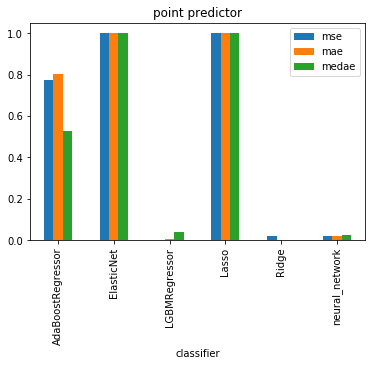

In [14]:
fig,ax = plt.subplots()
point_df.groupby(['classifier']).mean().plot.bar(ax=ax)
ax.set_title('point predictor')

Text(0.5, 1.0, 'price predictor')

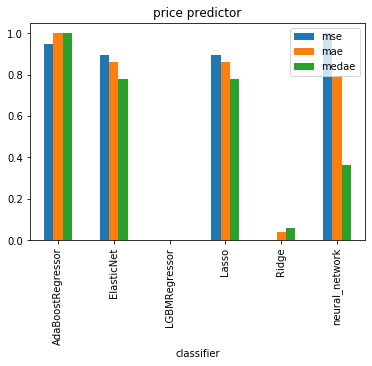

In [13]:
fig,ax = plt.subplots()
price_df.groupby(['classifier']).mean().plot.bar(ax=ax)
ax.set_title('price predictor')

In [20]:
# sanity check for keras model
y_pred= model.predict(X_val[20:30])
y_pred

array([[0.48864475, 0.01001792],
       [0.37232235, 0.00499718],
       [0.30094522, 0.00749345],
       [0.41734082, 0.00713981],
       [0.42000964, 0.00739289],
       [0.33142668, 0.00713353],
       [0.32321715, 0.00684151],
       [0.2710091 , 0.00886011],
       [0.42425302, 0.0060446 ],
       [0.478989  , 0.00701914]], dtype=float32)

# prediction against ground truth for neural network model

[]

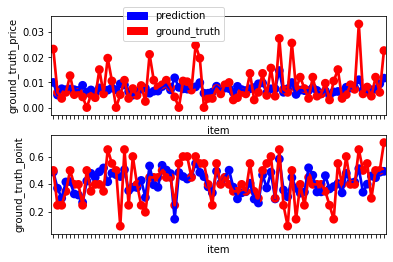

In [73]:
# prediction of 
import seaborn as sb
import matplotlib.patches as mpatches
%matplotlib inline
prediction_range = (20,100)
y_pred= model.predict(X_val[prediction_range[0]:prediction_range[1]])
df= pd.DataFrame({'prediction_price':y_pred[:,1],
                  'prediction_point':y_pred[:,0],
                  'ground_truth_price':Y_val[prediction_range[0]:prediction_range[1],1],
                  'ground_truth_point':Y_val[prediction_range[0]:prediction_range[1],0],
                  'item':range(y_pred.shape[0])})

fig, (ax,ax2) = plt.subplots(2)
line1=sb.pointplot(x='item', y='prediction_price', data=df, ax=ax, color='b',label='prediction')
line2=sb.pointplot(x='item', y='ground_truth_price', data=df, ax=ax, color='r',label='ground_truth')
line3=sb.pointplot(x='item', y='prediction_point', data=df, ax=ax2, color='b',label='prediction')
line4=sb.pointplot(x='item', y='ground_truth_point', data=df, ax=ax2, color='r',label='ground_truth')
# labels = ax.get_xticklabels() 
ax.set_xticklabels('', rotation=-30)
# line1.set_label('prediction')
colors=['b','r']
answers=['prediction','ground_truth']
pat = [mpatches.Patch(color=col, label=lab) for col, lab in zip(colors, answers)]
ax.legend(handles=pat, bbox_to_anchor = (0.2,0.7))
# plt.legend(labels=['prediction','ground_truth','dsfs','sdfsf'])
ax2.set_xticklabels('', rotation=-30)
# sb.plt.show()

In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#linear regression
lr = LinearRegression()   # instantiate
lr.fit(X_train, Y_train)                         # fit
y_pred = lr.predict(X_val)
evaluate(y_pred,Y_val,y_col)

ycol is: ['points', 'price']
mean squared error is: [4317400221377447.0, 3714676496054658.5]
mean absolute error is: [878839.840054, 815193.200496]
median_absolute_error is: [0.084036, 0.002775]


# Parameter tuning for neural network model

In [92]:
result_nn_test='''n=1
mean squared error is: [0.015761, 0.000144]
mean absolute error is: [0.099481, 0.005806]
median_absolute_error is: [0.083797, 0.003562]
n=2
mean squared error is: [0.017137, 0.000125]
mean absolute error is: [0.104829, 0.005159]
median_absolute_error is: [0.089069, 0.003031]
n=3
mean squared error is: [0.017247, 0.000132]
mean absolute error is: [0.105424, 0.005194]
median_absolute_error is: [0.090544, 0.002942]
n=4
mean squared error is: [0.0171, 0.000136]
mean absolute error is: [0.104554, 0.005303]
median_absolute_error is: [0.089746, 0.002787]
n=5
mean squared error is: [0.016843, 0.000123]
mean absolute error is: [0.103504, 0.00507]
median_absolute_error is: [0.088795, 0.002922]
n=6
mean squared error is: [0.017945, 0.000138]
mean absolute error is: [0.108091, 0.006828]
median_absolute_error is: [0.091634, 0.005247]
n=7
mean squared error is: [0.018248, 0.000137]
mean absolute error is: [0.109084, 0.006664]
median_absolute_error is: [0.091868, 0.005275]
n=8
mean squared error is: [0.023176, 0.000146]
mean absolute error is: [0.124428, 0.006461]
median_absolute_error is: [0.110542, 0.004709]
n=9
mean squared error is: [0.023492, 0.000142]
mean absolute error is: [0.125361, 0.006391]
median_absolute_error is: [0.120772, 0.0049]
n=10
mean squared error is: [0.023501, 0.000142]
mean absolute error is: [0.125399, 0.006542]
median_absolute_error is: [0.119903, 0.005285]'''


In [192]:
import re
import ast
result_dict_nn={'n':[],'mae_price':[],'mae_point':[]}
for line in result_nn_test.split('\n'):
    if 'n='in line:
        match = re.findall(r'1?[0-9]$',line)
        result_dict_nn['n'].append(int(match[0]))
    if 'mean absolute error is:' in line:
        match = re.findall(r'\[.*\]',line)
        if match:
            mae = ast.literal_eval(match[0])
            result_dict_nn['mae_point'].append(mae[0])
            result_dict_nn['mae_price'].append(mae[1])
            
result_dict_nn

{'n': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'mae_price': [0.005806,
  0.005159,
  0.005194,
  0.005303,
  0.00507,
  0.006828,
  0.006664,
  0.006461,
  0.006391,
  0.006542],
 'mae_point': [0.099481,
  0.104829,
  0.105424,
  0.104554,
  0.103504,
  0.108091,
  0.109084,
  0.124428,
  0.125361,
  0.125399]}

Text(0.5, 1.0, 'number of hidden layers against mean absolute error')

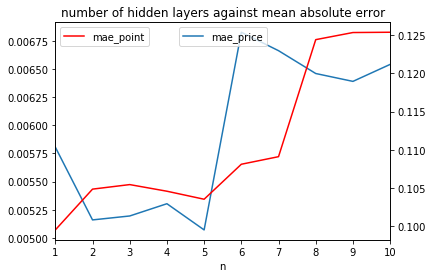

In [212]:
fig,ax = plt.subplots()
ax1=ax.twinx()
df=pd.DataFrame(result_dict_nn)
df.plot('n','mae_price',ax=ax)
df.plot('n','mae_point',color='red',ax=ax1)
ax.legend(loc=9)
ax.set_title('number of hidden layers against mean absolute error')